In [221]:
from poloniex import Poloniex
polo = Poloniex()
import os, datetime
import matplotlib.pyplot as plt
%matplotlib inline
import plotly_express as px

#input date time and Symbol
startdate = '1/11/2010'
end_date= '31/12/2018'
Symbol = 'USDT_BTC'



#pull HISTORICAL DATA
#86400 denotes daily
import pandas as pd
Daily_data =polo.returnChartData(Symbol, 86400, start= datetime.datetime.strptime(startdate, "%d/%m/%Y").timestamp(), end= datetime.datetime.strptime(end_date, "%d/%m/%Y").timestamp())
Daily_data = pd.DataFrame(Daily_data)
Daily_data['True Date']= pd.to_datetime(Daily_data['date'], unit='s')
Daily_data['Year']=  Daily_data['True Date'].dt.year
#moving average columns
Daily_data['MA10'] = Daily_data['close'].rolling(10).mean()
Daily_data['MA50'] = Daily_data['close'].rolling(50).mean()
Daily_data['EMA10'] = Daily_data['close'].ewm(span = 10).mean()
Daily_data['EMA50'] = Daily_data['close'].ewm(span = 50).mean()
#Rules
#Signal cross of 10 over 50 Buy at close price Logic 10>50 or short 10<50
#Always gong to be long or short
#Use closing prices
#Profit/Loss -- For buy (10>50) profit = close on day of cross until until 10<50 Reversal.
#Profit/Loss -- For Sell this is the reverse
#charts: Line chart, sma's and closing price
#profit LOSS calculator

Daily_data.head(2)

,close,date,high,low,open,quoteVolume,volume,weightedAverage,True Date,Year,MA10,MA50,EMA10,EMA50
0,244.00,1424304000,244.0,225.00,225.000000,0.193117,46.276313,239.627778,2015-02-19,2015,NaN,NaN,244.0000,244.0000
1,240.25,1424390400,245.0,240.25,240.250118,0.230429,55.894897,242.568479,2015-02-20,2015,NaN,NaN,241.9375,242.0875


In [222]:
#drop the Nan to get to the start of the moving averages
Daily_data_SMA= Daily_data.dropna()
#set long short or neutral. We will start at 0
trade_direction = 0

#set start of trade direction-- if 10>50 we are waiting to short and vice versa
#Check if MA10 > MA50 or vice versa. IF greater than 50 set trade_direction to 1
#if ma10<MA50 set trade dircetion to -1
if (Daily_data.iloc[0]['MA10'])>(Daily_data.iloc[0]['MA50']):
    trade_direction = 1
elif (Daily_data.iloc[0]['MA10'])<(Daily_data.iloc[0]['MA50']):
    trade_direction = -1

trade_direction
    

0

In [223]:
#create the long/short column:
def buy_sell (row):
   if row['MA10'] > row['MA50'] :
      return 'LONG'
   if row['MA10'] < row['MA50'] :
      return 'SHORT'    
longshort = Daily_data.apply (lambda row: buy_sell(row), axis=1)
Daily_data_SMA['Go Long or Short'] = longshort


C:\Users\Jonas\Anaconda3\envs\class\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [224]:
#Find where the column values change
#this function compares current value to previous value and if they are the same = True
#If current value does not equal then it is false.
#Therefore all the "false" tags will have an exit price for our long and a entry price for our short
Daily_data_SMA['entry and exit'] = Daily_data_SMA['Go Long or Short'].eq(Daily_data_SMA['Go Long or Short'].shift())
Daily_data_SMA.to_csv('test.csv')

C:\Users\Jonas\Anaconda3\envs\class\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [225]:
#Lets pull out all the entry and exit points with closing price and Short or long column
EntryandExit = Daily_data_SMA.loc[Daily_data_SMA['entry and exit'] == False]
EntryandExit
#NEXT Calculate the profit/Loss per trade
#Step 1 Change all the rows named SHORT to Negative
EntryandExit.loc[EntryandExit['Go Long or Short'] == 'LONG', 'close'] = EntryandExit['close']*-1
#Calculate the profit or loss on the trades. Fist column will be nan after that the profit or 
#loss is calculated on a per trade basis

#EntryandExit['Running Total'] = EntryandExit['Profit or Loss'].cumsum()
EntryandExit['Profit or Loss'] =  EntryandExit.close+EntryandExit.close.shift(1) 
EntryandExit.head(4)

C:\Users\Jonas\Anaconda3\envs\class\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,close,date,high,low,open,quoteVolume,volume,weightedAverage,True Date,Year,MA10,MA50,EMA10,EMA50,Go Long or Short,entry and exit,Profit or Loss
49,269.0000,1428537600,269.0000,240.88,245.559495,3.726719,910.717567,244.375177,2015-04-09,2015,254.256118,257.183195,255.642158,257.259788,SHORT,False,NaN
84,-243.2662,1431561600,249.5324,236.01,240.771396,1.312979,318.918726,242.897107,2015-05-14,2015,238.411853,238.175409,239.651958,238.934393,LONG,False,25.7338
105,225.0000,1433376000,229.0000,225.00,229.000000,0.060991,13.935990,228.492048,2015-06-04,2015,233.986346,234.056422,233.025019,237.304057,SHORT,False,-18.2662
118,-250.0000,1434499200,250.0000,234.32,234.320000,1.438727,357.929989,248.782420,2015-06-17,2015,236.731800,236.513993,237.846066,236.599597,LONG,False,-25.0000


In [226]:
#trade statistics
total_trades= len(EntryandExit)
Total_profit_points = EntryandExit['Profit or Loss'].sum()
largest_drawdown = EntryandExit['Profit or Loss'].min()
largest_winner = EntryandExit['Profit or Loss'].max()

print(f"There were {total_trades} trades made for the Simple Moving Average Strategy. The Total Profit/Loss from the \
strategy was ${Total_profit_points}. The largest single winner was ${round(largest_winner,2)} and the largest drawdown was ${round(largest_drawdown,2)}")

There were 33 trades made for the Simple Moving Average Strategy. The Total Profit/Loss from the strategy was $4196.714450660003. The largest single winner was $6889.4 and the largest drawdown was $-2319.99


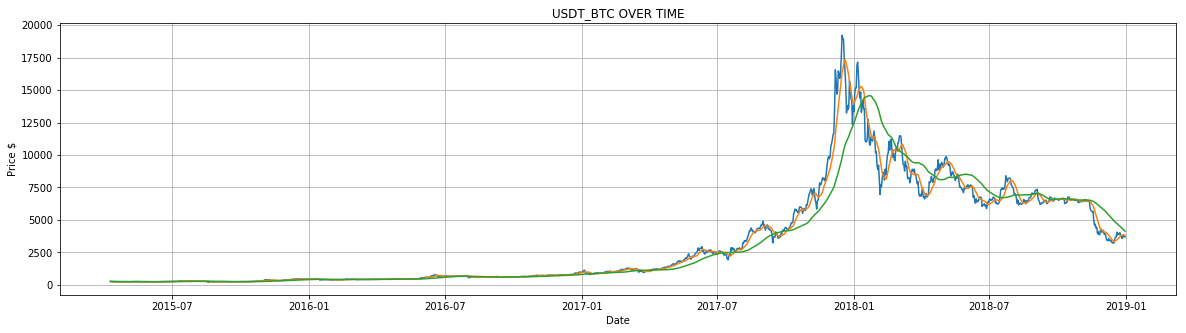

In [227]:
#Plot price and moving averages
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,5)) 
plt.plot(Daily_data_SMA['True Date'], Daily_data_SMA['close'])
plt.plot(Daily_data_SMA['True Date'], Daily_data_SMA['MA10'])
plt.plot(Daily_data_SMA['True Date'], Daily_data_SMA['MA50'])

# Incorporate the other graph properties
plt.title(f"{Symbol} OVER TIME")
plt.ylabel("Price $")
plt.xlabel("Date")
plt.grid(True)

# Save the figure
#plt.savefig("Latitude_vs_Wind.png")

# Show plot
plt.show()


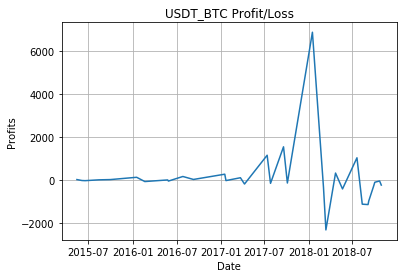

In [228]:
#Plot profit line
import matplotlib.pyplot as plt
plt.plot(EntryandExit['True Date'], EntryandExit['Profit or Loss'])

# Incorporate the other graph properties
plt.title(f"{Symbol} Profit/Loss")
plt.ylabel("Profits")
plt.xlabel("Date")
plt.grid(True)

# Save the figure
#plt.savefig("Latitude_vs_Wind.png")

# Show plot
plt.show()